In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import mitsuba as mi
import drjit as di
import numpy as np
from matplotlib import pyplot as plt

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [3]:
scene_dict = {
    "type": "scene",
    "integrator": {
        "type": "path",
        "max_depth": -1
    },
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f().look_at([0, 0, 4], [0, 0, 0], [0, 1, 0]),
        "sampler": {
            "type": "independent",
            "sample_count": 128
        },
        "film": {
            "type": "hdrfilm",
            "width": 512,
            "height": 512
        }
    },
    "face": {
        "type": "obj",
        "filename": "../meshes/low-res.obj",
        "to_world": mi.ScalarTransform4f().translate([0, -1, 0]).scale(0.0857405).translate([0, 5.0986, 0]),
        "bsdf": {
            "type": "pplastic",
            "diffuse_reflectance": {
                "type": "bitmap",
                "filename": "../textures/diffuse_albedo.exr"
            },
            "specular_reflectance": {
                "type": "bitmap",
                "filename": "../textures/specular_intensity.exr"
            },
            "alpha": 0.8
        }
    },
    "polarizer_light": {
        "type": "sphere",
        "to_world": mi.ScalarTransform4f().rotate([1, 0, 0], 90).scale(9),
        "bsdf": {
            "type": "polarizer",
            "theta": {
                "type": "spectrum",
                "value": 90
            }
        }
    },
    "polarizer_cam": {
        "type": "obj",
        "filename": "../meshes/plane.obj",
        "to_world": mi.ScalarTransform4f().look_at([0, 0, 3.5], [0, 0, 0], [0, 1, 0]),
        "bsdf": {
            "type": "polarizer",
            "theta": {
                "type": "spectrum",
                "value": 0
            }
        }
    }
}

In [4]:
def spherical_to_cartesian(radius, phi, theta):
	return mi.ScalarTransform4f().rotate([0, 1, 0], phi).rotate([1, 0, 0], theta) @ mi.ScalarPoint3f([0, 0, radius])

def add_lights(scene, size, radius, thetas, phis):
    assert len(thetas) == len(phis)

    for i, theta, phi in zip(range(len(thetas)), thetas, phis):
        scene[f"light{i}"] = {
            "type": "disk",
            "to_world": mi.ScalarTransform4f().look_at(spherical_to_cartesian(radius, phi, theta), [0, 0, 0], [0, 1, 0]).scale(size),
            "bsdf": {
                 "type": "diffuse"
            },
            "emitter": {
                 "type": "area",
                 "radiance": {
                      "type": "rgb",
                      "value": 4
                 }
            }
        }

In [5]:
x = np.linspace(-90, 90, 50)
y = np.linspace(-90, 90, 50)
phis, thetas = np.meshgrid(x, y)

phis = phis.flatten()
thetas = thetas.flatten()

add_lights(scene_dict, 0.1, 10, thetas, phis)

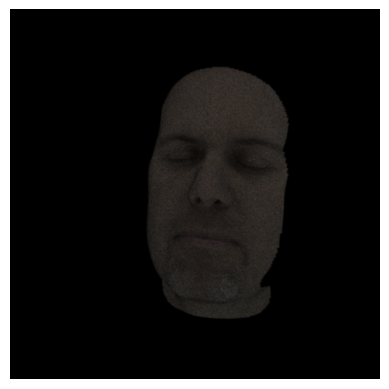

In [6]:
scene = mi.load_dict(scene_dict)
image = mi.render(scene)

plt.axis("off")
plt.imshow(image ** (1.0 / 2.2))
plt.show()